# Using R from Haskell: Stock market demo

## Setup 

First, we set up HaskellR.

In [1]:
:ext QuasiQuotes
import qualified H.Prelude as H
H.initialize H.defaultConfig

Then, we set up R, loading all the packages we need.

In [2]:
[r|
  library(keras)
  library(dplyr)
  library(ggplot2)
  library(lubridate)
  library(tidyr)
  library(zoo)
  library(forecast)
  library(xts) |] 

0x00007f74c42449a0

## Our data's available in Haskell

Let's assume our data is available as part of a larger trading application, written in Haskell.

Here we just load stock market data from files.

In [3]:
getAsDouble :: String -> [Double]
getAsDouble =  map read . lines
googl <- fmap getAsDouble (readFile "googl.csv") 
intl <- fmap getAsDouble (readFile "intl.csv") 
nvda <- fmap getAsDouble (readFile "nvda.csv") 
dates <- fmap lines (readFile "dates.csv") 

Now we'd like to visualize our data (as time series, preferredly) and do some exploration.

## Explore the data - using R

How? Well - we do what we always do - use ggplot2...

The data shown are stock returns (= relative price differences). 
We compare returns for Google, Intel and Nvidia starting from 2017-01-01.

<img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAeAAAAHgCAMAAABKCk6nAAADAFBMVEUAAAABAQECAgIDAwMEBAQFBQUGBgYHBwcICAgJCQkKCgoLCwsMDAwNDQ0ODg4PDw8QEBARERESEhITExMUFBQVFRUWFhYXFxcYGBgZGRkaGhobGxscHBwdHR0eHh4fHx8gICAhISEiIiIjIyMkJCQlJSUmJiYnJycoKCgpKSkqKiorKyssLCwtLS0uLi4vLy8wMDAxMTEyMjIzMzM0NDQ1NTU2NjY3Nzc4ODg5OTk6Ojo7Ozs8PDw9PT0+Pj4/Pz9AQEBBQUFCQkJDQ0NERERFRUVGRkZHR0dISEhJSUlKSkpLS0tMTExNTU1OTk5PT09QUFBRUVFSUlJTU1NUVFRVVVVWVlZXV1dYWFhZWVlaWlpbW1tcXFxdXV1eXl5fX19gYGBhYWFiYmJjY2NkZGRlZWVmZmZnZ2doaGhpaWlqampra2tsbGxtbW1ubm5vb29wcHBxcXFycnJzc3N0dHR1dXV2dnZ3d3d4eHh5eXl6enp7e3t8fHx9fX1+fn5/f3+AgICBgYGCgoKDg4OEhISFhYWGhoaHh4eIiIiJiYmKioqLi4uMjIyNjY2Ojo6Pj4+QkJCRkZGSkpKTk5OUlJSVlZWWlpaXl5eYmJiZmZmampqbm5ucnJydnZ2enp6fn5+goKChoaGioqKjo6OkpKSlpaWmpqanp6eoqKipqamqqqqrq6usrKytra2urq6vr6+wsLCxsbGysrKzs7O0tLS1tbW2tra3t7e4uLi5ubm6urq7u7u8vLy9vb2+vr6/v7/AwMDBwcHCwsLDw8PExMTFxcXGxsbHx8fIyMjJycnKysrLy8vMzMzNzc3Ozs7Pz8/Q0NDR0dHS0tLT09PU1NTV1dXW1tbX19fY2NjZ2dna2trb29vc3Nzd3d3e3t7f39/g4ODh4eHi4uLj4+Pk5OTl5eXm5ubn5+fo6Ojp6enq6urr6+vs7Ozt7e3u7u7v7+/w8PDx8fHy8vLz8/P09PT19fX29vb39/f4+Pj5+fn6+vr7+/v8/Pz9/f3+/v7////isF19AAAgAElEQVR4nOydBVwUyx/AlxAQCQVbsRWxC7vQZ2MXdqHPFjvADux42K3PxO586sMu7MAu6n4IKoL63sn9Z7b3dm/3RLj/nW9/nw+7M7M/Zub2uzv5m1lCp8ovLcT/OwOqpK+ogH9xMQD4n/lTNnCn2wtMlyFV0lYMAA7bppv1hjkljVEBW6wYALzuqm77X8xp2TUa8GdOviV9VpQvyiqf/1G4nqyQTtI3IxIxIiPJX5VVlH/yP2lzV1L1o0AkcoBDnulOHaRPV3fHYsCjuw75l5MU7b+K8l1Z5V+dwnWtQjraFCMSMSIj35XjMSIWXdrcFa3SXZGI53OESBTe4B1/0afxUyf2PK7T3bka/oGT758/KMpXZZWPOgWFpET564nfjUjEiIwk/6Os8klRJUVZxZi78ilFWUc/nvgfAxy2UzfnDXuKpYto3uuv/SAuEvQlWVklTqeg8ClB/nqC1ohEkpR1Er8qq7xXVEmJV07JiLsS/11ZRxTPjwH+Z+GcDbqIP8iTCphW+ZUASwsvOhWwlKiA9eVXAbzqDXlSAevLrwI4xwHypALWl18FsMsf5EkFrC+/CmC7EeRJBawvvwjgGKIteVYB68svAvgVUYk8q4D15RcB/JjISp5VwPryiwC+ZW/9Ep9VwPryiwC+lD33OXxWAevLLwL4TL5qG/FZBawvvwjgI55+U/FZBawvvwjg3WXH9cZnFbC+/CKAt1RdUQ+fLR1wPCfaT/GK8kVZJUGnoPD5o/z1j9+NSCRZWSfpm7LKB4OX1vucLIzPKYZVWDHirnxMUdbRjycuLQAncvI9OVFRvimrfNYpKHxJkr+e9F05EWMy8vVfZZXPBi+tbPbC7gM6pyjk1sjMJKUo6+jHk6AW0bLyc0X03DbgFA6WX0TzolMB82VaZyixD1TAYvlFAI/vA00XgwpYLL8I4IDBMDAAVMBi+UUA9x8Fs1uDClgsvwjgnkGwswKogMXyiwDuOBOuuIEKWCy/COAWCyHS5pkKWCy/COCGywHynlEBi+UXAVxrA0CNDSpgsfwigL13AHSZpAIWi2UDvlWadpTaBxDYQwUsFssGvMUqknIUPg6w2kcFLBbLBjyFCKccecIAThSwJMD8TViSgsZN+6oClgDclThKOdyuoRtsG21BgPmbsBzepdt6UgUsAbiq9TrK4XgXHVxuWhBg/iYsj0F38KwKWAKwe9kZlMP6KTqU2mNBgPmbsOh0V8cm6XTdfNqncKJL+WG5p5UITEU8aRxB6uN5bzN8NOn4QiShY9uV/8/MJP/wG8xuwpKyc0EiCop5F80zAfpxmyyN819iFYuyyUrQCzhZaHY70vHC6j06DhlmQTZZ/E1YLq5LoUN5BcKPF9HHiS1iFYsuokMabKhOOu5lxMd5LS2oiOZvwrJ8yJgxf/884InEIrGKRQMeNvB4QdJxHc8kQWhZCwIsLbzofhxwfZfxYhXLAryzvyCg2YLb5KsLYbnx8Xrm/zTgaCc/f7GKZQHuVlUQ4Hkw2gY3n+FEYXyMsnn6XwZ8LO/85mIVywJcwIvvj7F7CDnOY9eBkmSAx+n/MuCJfpurilUsCvBtIhfff80VoFwodu2k1vfXXvtfBuwTcryQWMWiAP/hlZHv31YRoDG5u86GWmRAt6BfE/DNACOyEJUpPNxZrGJRgNuPJiJ5/mkdAXqRDccVDciAoG6/JuDlGZ4pZ+GYB7wl3ohULAnwpxynUa3LSfdAgAk9sWsR1bpYWzuVgLd0EfrNDPBIYrVyFoL8AFxuiFR+GvCdNgoRQJoBvpElNtslnr/6BoCQxtgV3IEMOJ0vlYCHlRP6zQxwa492ylnwCQEoclSk8tOAD2ZXiADSDPB8X+EvyB5GDm4gmdidDHhq+y11gBvmEvrNDHCZ6VmilbIQjRffVd8oUvlpwJscFCKANAPsOxcq7eC8z2zeAZwnn6/Rv1NBmZ+mDrCHbazAb16ANU7h+Q4qZeFoPnRoOU+k8tOAQwTtHmlJG8Axma9A/ZWc/0R+dHhmHYWOQ+hmZtnjCHDEXvl4xIBf2tg+FgSYF+B79rH+g5WyENgJHfqOFqn8NOAZxCOFGNIK8Klc76HtbM6/tD4+Ot5GB/9xVFCL5Qjwkvzy8YgBH8uf629BgHkBPlAcQospZcFnKVB2h3ry04BHEdcUYlAA/CyMPCkDntTpPfTmDacHkOVyoWPo0GUqFTR0NAI8kHggG48Y8KLG1HgJK+YFeGEziHS6Lp+FKMdb6LikKbzaIVT5acB9idMKMSgAnkMNUpCAV92XUfRZ+R6GD+T8vvPwsRY22mk7hwpa2BYBrm+1QTY3YsD9AhouFQT83wDzPvLBfXVlSMCHD81ny38X5EQBfNzp/SGkoFDlp7+64kccUogBJfJF5mL/wuQJf3UFXDYZ1tM4Rnz6MKMrF+B1GB87zUAH32VU0IHynz58yFtrsGxu+F9LiSE/ZFN3bfcpAhUTfHXlBwA3Wfrhw/I68lmYSN6Yc/k/tMwoVNED/EIUhxLgRsRWeYUPCoAbUjnCgA8SCwzrHS2c/OnDUl/W/97hMT6N6Y8O9ddRYXdcPn14Z7O6smxu+GD65HmPjjkujRkgUPm/AeYVCFwRXewQwCP7F7KFSN1l+HjHIdqVeCpQERbRYVlEcSgV0VUyLJVXAIUiuiARgU+4iP7daqxhvdE9Et/Dhhqs/wY18LrAFx2q/UmFRWd4AsfzP7R7xygdfSKOCN2Vy7coZ6hb/i2obM0QOae1QEWuiD41hYtHIOkFOIYcvqu0TiIvbBYiybYmRFltz5f9vEBFCHgV8RD0RAmwZ4FgeQWQBxxp60xuI4oBF6ghMWPNSJW1CPC+Uqx/R3nytBOfyu9ilDbBHw2h4BFGqdAS
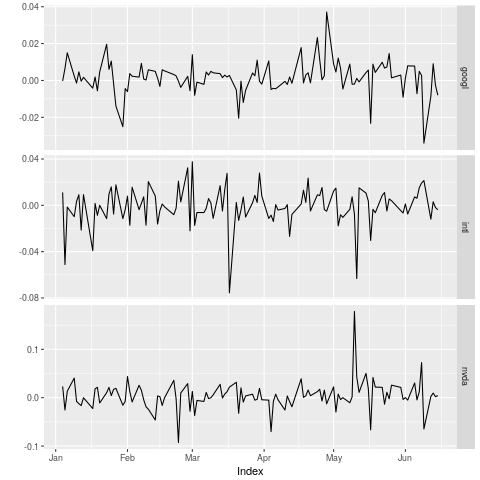

In [4]:
[rgraph|
  df <- data.frame(tstamp = ymd(dates_hs), googl = googl_hs, intl = intl_hs, nvda = nvda_hs) 
  tss <<- read.zoo(df)
  autoplot(tss) + facet_free() |]

We can quickly look at (auto-) correlations...

<img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAeAAAAHgCAIAAADytinCAAAgAElEQVR4nO3deUATZ/4/8Gc4VLCioGJFQRAVVLxA228vBS1WAavW0tquutD1wKPFstpl2V/Rdb2qVbDbr0ChXRVdbem3ntB4olDUqq22gqicgiKiHKKcIcnvj3Rn0+HIZDIzmQzv11/J48w8z+Q9+RgmmWcojUZDAABAeixMPQAAAGgbCjQAgEShQAMASBQKNACARKFAAwBIFAo0AIBEoUADAEgUCjQAgEShQAMASBQKNACARKFAAwBIFAo0AIBEoUBzsX79+pCQEFOPAtrFCGj9+vWDBw9et26d7jKbN2+eN28eyy2AyNgkyMb48eMPHTrE58jE1XkLdFFR0fDhw728vLy9vU+fPl1SUvL888/37NkzODhYqVQynjIWNvXYO6OO8+o4oC+//DI6Ovrrr7/Wbayqqqqtrd24caOvr6+Tk9PEiRObmpoOHDjw8ssvi7hbnQjvCTKy8/Pzi4+Pr66utrS0zMjI8PDwGDZsWHl5OSHk7Nmz3t7ebm5umzdvFm+H+dB5C3RMTMzIkSMPHjyYnZ2tVCq3bNni5ORUUFBw5cqVQ4cOMZ4yFjb12DujjvPqOKDXX389NDQ0Jibm2rVrKpVK22hnZ+fg4FBfX9/c3JydnZ2fn5+VlRUXF3f9+nWFQiH6/skf7wkysgsKCjp79uyFCxe8vb137949YcKEtLQ0bYEuLCxcu3bthg0b4uLixN5t43TeAl1QUDBx4sShQ4cOGzaMEFJcXOzr69unTx8fH5+CggLGU8bCIL6O8+ogoLS0tOPHj8+cOTMmJua1116zsGAe86NHj3ZwcHBycqqtrV26dOmoUaOmTZsm0l51JkIkqJudtkBnZmYGBgbm5+f7+fkNGTLEzc2NEOLm5vbXv/51w4YNdHE3F523QDs5OV28eLGkpCQvL48Q4urqmpGRUV1dffXqVVdXV8ZTxsIgvo7z6iCgrKysMWPGxMXFnT9//qWXXqIoquOO1Gq1UPvQuQmdoIeHR48ePZKTkwMDAwcNGpSZmVlUVFRUVEQIiYmJWbJkSXh4uND7yLvOW6A//PDDixcv+vr6Ojg4EEJWr15dWlrq5uY2bty4OXPmMJ4yFgbxdZxXBwGFhobm5uaOGDEiODi4vLz85s2bHfQyYsSIoqKitLQ0AfeksxIhwaCgIKVS6ePjExkZmZmZOWXKFFdXV2tr66CgoI0bN6ampmo0mrq6OmH3k1dUp73l1ZEjR2pqaiZPnjxmzJjTp0+PHTuWr4VBCB1HgICkDwly0HkLdHFxcVxcXF5eXkBAwMKFC3lcGITQcQQISPqQIAedt0ADAEhc5z0HDQAgcSjQAAAShQINACBRKNAAABKFAg0AIFFWHNZJTU2NiYmhKEqlUllYWERERAQEBPA+MhABopQNRClLXAp0YmKiQqGwsrIihKjV6pCQkDYPhZdfftnGxsbYAYLhqqqqDhw4MHToUL1LsozSz89PuwyIrLq6eteuXV5eXnqXZBnla6+9hmvZTaKmpiYhIcHb29ugtbi86yiKUigUXl5eFEXl5ua2tLS0uZi1tfXJkyc5bB+M9NFHH9XU1LBZkmWUhBBEaRLR0dHV1dVslmQZZXNzc3p6Oq9jBFY2bNhQWVlp6FpcCnRCQkJSUlJKSopGo/H09IyNjeWwEZACRCkbiFKWuBRoR0fHqKgo+ml8fHxYWBh/QwLxIErZQJSyxMOJRQ8PD+2DrVu3njhxgm6/cuUK/fj8+fPXr19fsmSJ8d2BcOgod+zYcezYMbr98uXLJhoRcERHGRcX991339HtiNK88FCg/fz8tA9Wr169evVqut3e3p5+XFtby/JUGpgQHWV4eLju5Lm6UYJZoKNcunTp0qVL6XZEaV64FOi5c+dWV1fr/kLDrG/L2JkhStlAlLLEpUDHxcXNnz8f8csAopQNRClLXK4ktLe337lzJ+9DAfEhStlAlLLE8VJvFxcXfscBpoIoZQNRyg/m4gAAkCgUaAAAiUKBBgCQKBRoAACJQoEGAJAoFGgAAIlCgQYAkCgUaAAAiUKBBgCQKD7vY7Rz586zZ8/ST5uamnjcOIgpMTFR9xYqjY2NJhwMGGP37t2pqan0U0RpXvgs0O++++60adPop7pzQ4N5eeutt6ZMmUI/RZTma/bs2a+88gr9FFGaFz4LdK9evXr16kU/pSiKx42DmHr27NmzZ0/6KaI0X3Z2dnZ2dvRTRGlecA4aAECiUKABACQKBRoAQKJQoAEAJAoFGgBAolCgAQAkCgUaAECijCrQGo1GqVTyNRQwIUQpG4hSTrhcqLJv376KigpfX9/Fixfb2Ni8+eabH3zwAe8jAxEgStlAlLLE5RP00aNHV65cuXv37pSUlIyMjDNnzvA+LBAHopQNRClLXAp0t27dDhw44OTkdOjQoR9//LGlpYX3YYE4EKVsIEpZ4nKKY+fOnfv27cvPz3/69OmjR4/i4+N5HxaIA1HKBqKUJS4F2tbWdtGiRYsWLdI+jY+PDwsLI4Rcvny5uLiYXgz/h0tfe1H+/PPPBQUF9GKIUvrai/KXX365ffs2vRiiNC88zGbn4eGhfVBXV1ddXW38BsFU2otSo9GYaETAEaKUBy4FOjU1NSYmhqIolUplYWERERGhbff19fX19aUX+8tf/sLLEEE47UX5yiuv6E4ijCilr70oX3zxxRdffJFeDFGaFy4FOjExUaFQWFlZEULUanVISEhAQADfAwMxIErZQJSyxKVAUxSlUCi8vLwoisrNzcVZLfOFKGUDUcoSlwKdkJCQlJSUkpKi0Wg8PT1jY2N5HxaIA1HKBqKUJS4F2tHRMSoqivehgPgQpWwgSlnCZEkAABKFAg0AIFEo0AAAEoUCDQAgUSjQAAAShQINACBR5lGgi4qK1Gq1qUcBACAq8yjQ69atKykpMfUoAABEpf9CFfqSpJUrV3a8ZGNjY0NDAw+DAlNramqqr6839SiAB4jSrOkv0EOGDGG5rcTExMzMTPppY2Mjx0GBqf3rX//SvWcSojRf+/btUygU9FNEaV70F+gXXnjhwYMHI0aM0Lvk+++///7779NP7e3tjRoamE5YWJh2unctRGm+3nvvvffee49+iijNi/5z0E1NTatWrfrkk09EGA0AAND0F2gnJ6e0tDTdv5IAAEAEbH/F0a9fP0HHAQAADPrPQWdnZ+/fv9/T01OE0QAAAE1/gU5MTJw8efKrr74qwmgAAICm/xSHn5/f119/PW3aNBFGAwAANP2foNesWZOWljZgwAARRgMAADT9n6AnTJiA6gwAID79BfrkyZPJycmVlZW6jZi6SDYQpWwgSvnRX6CvX79OCAkNDaVbtm3bNmnSpKCgoNLSUkLIrFmzhBsfCApRygaHKB88eJCeni780IA7/QXazs5u/vz5R44coVvOnDmTmZmZkJAQFhamUqmEHB4IC1HKBocoi4qKTpw4IfTAwBhcphutr69PT0/v37//8uXLIyMjMYOd+UKUsoEoZYlLgU5KSjpx4kRdXV1AQIC/v//AgQN5HxaIQyJR7t69G5/fjSSRKIFf+n9m15q7u/umTZu0j6dOnVpYWKh9vHXrVt2/mDCxofS1F+WOHTuOHTtGLyZ0lCkpKW+++Wb37t0F7UXe2osyLi7uu+++oxfDJ2vzwqVAM3h4eGgfrF69evXq1XQ7JjY0O3SU4eHh4eHhdDuiNDt0lEuXLl26dCndjijNC5cCnZqaGhMTQ1GUSqWysLCIiIjgfVggDkQpG4hSlrgU6MTERIVCYWVlRQhRq9UhISEBAQGtF1Ophv30EyGEODj81pKbS7Q333FwIG5uBrRUVrpev95FozFsrU7bUlnpqFZTHUX4H6yjHKqN0t6eDB5MCCE3b5K6Ot5aHj8eUlREeXnxv2Vzb3n0qE9LC59RqtVDtFH27Plby+3b
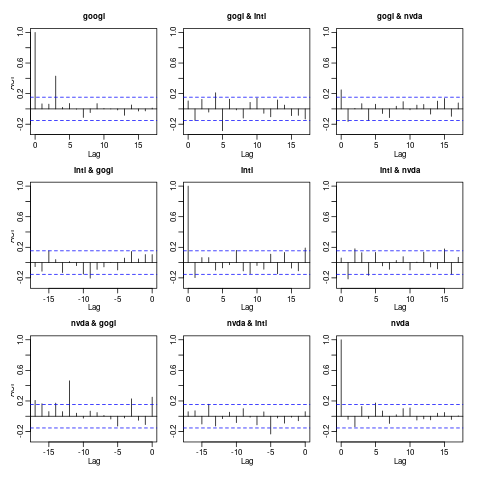

In [5]:
[rgraph|
  acf(tss, na.action = na.pass) |]

And sure, we can quickly do an auto.arima on one of the series!

## Let's get forecasting - using R's forecast package, of course!

<img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAeAAAAHgCAIAAADytinCAAAgAElEQVR4nOy9eXxU1f3/f2bNbNkTEglLEhLEQNhkNSBbUdxYVAS0Lv2AFLW1RdtqF+HzsbV8ba1L+/FrLVZUrLYKWhRRXBAlLAFlJyRITMhCMtnJNkuSud8/zs/zO73b3Jm528y8nw/+GG7u3Htn5t7Xfd3XeZ9zDAzDIAAAAEB/GLU+AAAAAIAfEGgAAACdAgINAACgU0CgAQAAdAoINAAAgE4BgQYAANApINAAAAA6BQQaAABAp4BAAwAA6BQQaAAAAJ0CAg0AAKBTQKABAAB0Cgg0AACATgGBBgAA0Ckg0AAAADoFBBoAAECngEADAADoFBBoAAAAnQICDQAAoFNAoAEAAHQKCDQAAIBOAYEGAADQKSDQAAAAOgUEOmRSUlIMHJ599lmtj0sGDh8+XFhYaDab//rXv6q2U7fbbTKZDAbD7bffTi8vKChgfcn5+fl/+ctfEEJNTU14SWdnZ2dnJ1lh9+7d+L3Hjx8nC0+fPh10Xwiht99+22AwVFRUKPxx0e9+97uUlJTOzs4w3jswMIA/FPdPPT09BoPBZrNFfICAjgCBDpOCgoIJFJmZmVofEZuJEycaDIavvvpK+lueeeaZ8+fPl5SUjBs3TrkDY7Ft27ZAIIAQev/99z0eD+uvubm5EyZMGD9+vNForK6ufvDBB7/88kuhTR06dAi/OHLkSEj7CgQCjz/++Pz588eMGYMQOnPmzHXXXZeampqdnb1ixYrq6mruphoaGm699dbs7Oz8/Pw1a9b09PRIXGfNmjW9vb3PPfec6LciiTB+YiDKYIAQSU5ORggdPHhQ6wMJwoQJExBCR44ckf6Wa6+9FiH0zjvvKHdUXGbPno0QstvtCKF3332XLB81ahS95MiRI+np6QihX//6142Njfjs7ejo6OjowK8TEhIWLVqEV16zZo3FYsFO89SpU0H39fbbbyOEtm3bxjBMZ2fnZZddhhCaOXNmXl4eQqigoKCnp4c+Zr/ff/nllyOErr766kmTJiGEbrjhBtbnElnntttuwyY61O8qEAh4PB6Px4P/S//E3d3d+EsIdZuAngGBDhkRge7q6vrJT34yatQop9M5adKkLVu2BAIBhmGwoKSnp+/fv3/y5Mlvv/02wzDnzp274YYb0tLShg0b9l//9V8dHR14Iy0tLXffffewYcOSkpK+973vHTt2DC//+OOPp0+f7nK5UlNTFyxYQJbv379/9uzZLpcrIyPjpptuOnPmDPPdpYvBu+NdjYZ+y8aNG3mPWegD1tTUjBo1at68eU8//fTQoUNHjBjx7LPPHjhwYPLkyU6nc+7cudXV1bxfZn19vcFgcLlcv/nNbxBCd9xxB/kTS6AZhrn55psRQk888QSvQF911VWpqan4eMaPHz9t2jSTyUQLtMi+Jk2alJ2d7ff7GYbZvn07QmjWrFmBQGBwcHD06NEIoQ8//JA+7E8++QQhNG/evEAg4Pf7hw0bhhCqq6uTuM6ePXsQQps2bWJ9G1jHP/nkE4ZhHnnkEYTQTTfdxDDMqVOnEEJDhw7t6uoiKsz6iYlAf/jhh8XFxYmJicuXL+feA/74xz+yLNrq1auFzsaQzgEa6eeD0FXAe7Y3NzePGjVqypQp77zzztixYxMTExcvXux2u3lPrdgABDpksEBffvnlV37HqlWrGIYJBALz5s1DCA0fPvyGG27ANu3ZZ59lvjvRnU7nsGHDMjIyduzY0d7enp6ebjabFy9efNVVVyGEpk+fjhXhyiuvRAiNGzcOL8/MzGxubq6pqbHZbGazef78+dOmTUMI5efnMwzT0tKSlJRkMBiWLl169dVXI4RycnI8Hs+HH344YsQIhNDvfve72tpaodXoz/Xhhx+OHz8eIfTQQw+dOnWKe8wiH/Cbb77BV7vNZisqKsKvLRbL6NGjXS4XQmj58uW8X+YzzzyD/4qT4sTERHJUtEAHAoH6+vrc3FyE0L59+3gF+qGHHkIIVVZW9vT0GI3GBx98kCXQQvuqr69HCC1duhSv9sEHH6xYseKNN97A/12+fDlCaOvWrfRhP/744wihDRs24P/eeuut5EYoZR2v12swGGbPns36NrAo//a3v2UYBn/V2dnZgUDg73//O0LoBz/4AW2TWT8x/hOOoXEihBD65S9/ydrFzp0777jjjjvuuGPFihV4nZ/+9KdCZ2NI5wCNxPNBaL9CZzs+HpPJZLVaJ0yYgH/fe++9l/fUig1AoEMGCzTNhAkTGIbZu3cvPnG7urrIf9PS0siJTl/DTz75JELogQceYBgmEAhMnz4dIbR79+6PPvoIITRmzJj+/n7mu6v673//+969e5csWfLkk08yDOPz+XBbUHt7+2effYYQKiwsbGpqYhjmkUceueOOO7A9oZ9/RVajwREH1kTuMYt8QHJBnjt3jmGYkpIShNAdd9wRCAQ+/vhjfD/j/TJnzJiBEHrjjTcCgUBhYSFCaMeOHfhPWKBpjEbjhg0b6O+TFui33noLIfTqq6/ikPqNN95gCbTQvt555x2E0MMPP8w9vKNHjzocDrvd3tDQQC//6U9/ihD605/+hP+7evVqhNCLL74ofZ3hw4fbbDaW98Q/0/XXXz84OJiYmIgbNurq6n74wx8ihP75z3+ycgxuxIEQev/99xmGeeqppxBC8+bN4/3ayeEVFhZ2dHQInY0hnQP0xiWeD0L7FTrbyfF8/vnnDMO89tprCKHi4mKhzxgDQCNhmNARx/HjxxFCJ0+eRAjddNNNiYmJCKE5c+ZkZ2fTZ5XD4bjlllvw6/LycoTQ888/bzAYjEZjWVkZ3sLZs2cRQiUlJWazGSH05ptvejyeO++8c86cOZs2bfJ6vUuXLi0oKPB6vQihwcHB4uLi5OTkb7755rLLLps5c6bD4fjTn/6EnSaNxNW40Mcc9AMOGzYMCx9+nJ83b57BYBg+fDhCaGBggLvxCxcuHDp0yGKxXH/99QaDYdmyZQghHAcTcCNhcXGxxWIJBAL4guc91EmTJlkslkOHDh0+fBghhK92KftqaWlBCHHvBy+//PJVV13lcDj27NkzdOhQ+k+sY8BhNzakEtcZNWqU1+tlNS2WlJQ4HI5Dhw6dPXu2u7t77dq1CKEjR44cPnzYYDAsWLCA94PT4A+IEJo6dSpCqK+vj3e1V1999dlnn01MTPz3v/+dkpIidDbilUM6B2iCng9C+xU62/Fmk5OT58yZgxCaMmWKyGeMDcxaH0CsQZdA4atxYGDAarUihOx2O/krNnfr1q3DpxpmzJgxn376KUKImHSz2YyVet++ffPnz09ISFi2bNlvfvObn/3sZ9gxZWZmVlVVPfPMM9u2bTt06NChQ4eefvrpI0eO4AuDIHE1LvQxi3xA+kMRWP/lgj1vf39/SkoKWfjee+/5fL6EhAT832eeeWbp0qUIoYaGhhEjRvzzn/8Uqn+w2WyTJk0qKytrb2/PzMzE7XtS9sVV/N7e3h/96EevvPJKcXHx9u3bud9SWloaQoiUymEXj6VH4jr4a2TtOiEhYc6cOR9++OEbb7yBELr33nv/+Mc/7tu37+TJk1OmTMnIyOCtFaExGo34R2HdLWjKysqw9L/++us4fxA6G/GLkM4BmqDng9B+hc52jNlsxgfAW24YY4CDlg1cmrZz5058Fe3bt+/ixYupqams6xZzxRVXIIRsNtvKlStXrlw5ZMgQr9frdDpxu/+nn36Kz/hHHnlk4sSJ77zzzvbt2wcGBn76059u3bp16tSp5Hx97733Nm7cOGHChIqKioqKihkzZly6dAnnJBjsO4KuJvsHlMK//vUvhNCoUaNItaLD4ejq6sLNayxycnJwcUVzc7PQBmfMmHHixIl9+/ZNnz6ddfWK7GvIkCEIoaqqKrzm4ODgkiVLXnnllZUrV5aVlRF1DgQCTU1NTU1N
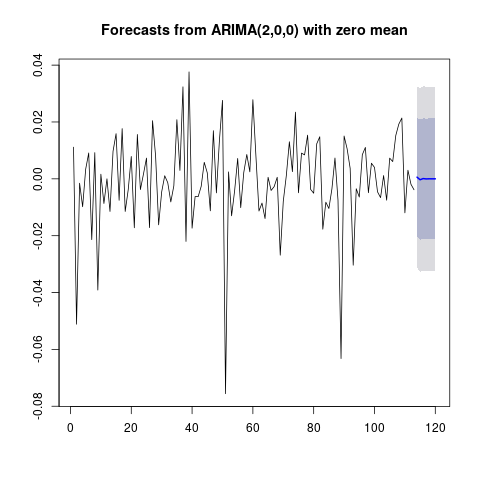

In [6]:
[rgraph|
  intl_ts <- as.xts(tss[,2])
  fit <- auto.arima(intl_ts)
  fc  <- forecast(fit, h=7)
  plot(fc)|]

## But deep learning is all the hype now... anything we can do?

### Sure: use _keras_ from R, with the keras package!

We need a TensorFlow installation for this, so let's check if R can find it!

In [7]:
[rprint| reticulate::py_config() |]  

python:         /nix/store/5kfn0xxh3ipjdyjly2d5wrmh4cidsm8k-python3-3.5.3/bin/python
libpython:      /nix/store/5kfn0xxh3ipjdyjly2d5wrmh4cidsm8k-python3-3.5.3/lib/libpython3.5m.so
pythonhome:     /nix/store/5kfn0xxh3ipjdyjly2d5wrmh4cidsm8k-python3-3.5.3:/nix/store/5kfn0xxh3ipjdyjly2d5wrmh4cidsm8k-python3-3.5.3
version:        3.5.3 (default, Jan 17 2017, 07:57:56)  [GCC 5.4.0]
numpy:          /nix/store/7xk7ylqagd3w72y1p39rlcsamx3hcxl3-python3.5-numpy-1.12.1/lib/python3.5/site-packages/numpy
numpy_version:  1.12.1
tensorflow:     /nix/store/qmr3h3f1s1x1dr64sb61igig8469imn6-python3.5-tensorflow-1.1.0/lib/python3.5/site-packages/tensorflow

python versions found: 
 /nix/store/5kfn0xxh3ipjdyjly2d5wrmh4cidsm8k-python3-3.5.3/bin/python
 /usr/bin/python
 /usr/bin/python3

First, we prepare our time series so it's in the correct shape for an LSTM with 10 timesteps...

In [8]:
[rprint| 
  lstm_num_timesteps <<- 7
  
  intl <<- unclass(tss[,2])
  
   # difference
  intl_start <- intl[1]
  intl_diff <- diff(intl)
  
  # normalize
  minval <<- min(intl_diff)
  maxval <<- max(intl_diff)
  normalize <- function(vec, min, max) {
    (vec-min) / (max-min)
  }
  denormalize <<- function(vec,min,max) {
    vec * (max - min) + min
  }
  intl_diff <- normalize(intl_diff, minval, maxval) 
  
  # create timesteps
  X_train <<- t(sapply(1:(length(intl_diff) - lstm_num_timesteps), function(x) intl_diff[x:(x + lstm_num_timesteps - 1)]))
  y_train <<- sapply((lstm_num_timesteps + 1):(length(intl_diff)), function(x) intl_diff[x])
  
  # Keras LSTMs expect the input array to be shaped as (no. samples, no. time steps, no. features)
  dim(X_train) <<- c(dim(X_train)[1], dim(X_train)[2], 1)
  num_samples <- dim(X_train)[1]
  num_steps <<- dim(X_train)[2]
  num_features <<- dim(X_train)[3]
  c(num_samples, num_steps, num_features) |]
  

[1] 105   7   1

Now, we create the model!  

In [9]:
-- at this point, there is no model yet
[rprint| model |] 

R Runtime Error: Error in (function ()  : object 'model' not found

In [10]:
[rprint| 
 
  batch_size <<- 1
  epochs <<- 20
  lstm_units <<- 4

  model <<- keras_model_sequential()
  |] 

Model
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
Total params: 0
Trainable params: 0
Non-trainable params: 0
________________________________________________________________________________

In [11]:
[rprint| 
 
  model %>% 
    layer_lstm(units = lstm_units, input_shape = c(num_steps, num_features)) %>% 
    layer_dense(units = 1) %>% 
    compile(
      loss = 'mean_squared_error',
      optimizer = 'adam'
    )
  model %>% summary()
  |] 

Model
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
lstm_1 (LSTM)                       (None, 4)                       96          
________________________________________________________________________________
dense_1 (Dense)                     (None, 1)                       5           
Total params: 101.0
Trainable params: 101
Non-trainable params: 0.0
________________________________________________________________________________

 
NULL

... and we train it!

In [12]:
[rprint| 
 
  model %>% fit(X_train, y_train, batch_size = batch_size, epochs = epochs)
  # model %>% save_model_hdf5(filepath = paste0(model_name, ".h5"))
  |] 

Epoch 1/20
105/105 [==============================] - 1s - loss: 0.3926     
Epoch 2/20
105/105 [==============================] - 0s - loss: 0.0538     
Epoch 3/20
105/105 [==============================] - 0s - loss: 0.0183     
Epoch 4/20
105/105 [==============================] - 0s - loss: 0.0183     
Epoch 5/20
105/105 [==============================] - 0s - loss: 0.0184     
Epoch 6/20
105/105 [==============================] - 0s - loss: 0.0181     
Epoch 7/20
105/105 [==============================] - 0s - loss: 0.0174     
Epoch 8/20
105/105 [==============================] - 0s - loss: 0.0177     
Epoch 9/20
105/105 [==============================] - 0s - loss: 0.0178     
Epoch 10/20
105/105 [==============================] - 0s - loss: 0.0177     
Epoch 11/20
105/105 [==============================] - 0s - loss: 0.0174     
Epoch 12/20
105/105 [==============================] - 0s - loss: 0.0175     
Epoch 13/20
105/105 [==============================] - 0s - loss: 0.0178 

Let's see how well the model predicts the data (of course, in reality we'd have a test series)!

<img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAeAAAAHgCAIAAADytinCAAAgAElEQVR4nOy9aZBk2Xme937nnLvmWlVdvU5jNkCAiCEAYqEgUqJMUgwGyaDoCDEUlm1Zctghh+UflhhW2JZDQuCHw0FKlGSSUogMmoYlirQdWqiFlLmBIAmAgwFATIMYLDOYtae7uvbc7nqWzz9uZnZ1d1V1dXfOdHb3eX5MTGdl3nvrVt73fvf9lkPMDI/H4/EsH+J+H4DH4/F4DscLtMfj8SwpXqA9Ho9nSfEC7fF4PEuKF2iPx+NZUrxAezwez5LiBdrj8XiWFC/QHo/Hs6R4gfZ4PJ4lxQu0x+PxLCleoD0ej2dJ8QLt8Xg8S4oXaI/H41lSvEB7PB7PkuIF2uPxeJYUL9Aej8ezpHiB9ng8niXFC7TH4/EsKV6gPR6PZ0nxAu3xeDxLihdoj8fjWVK8QHs8Hs+S4gXa4/F4lhQv0B6Px7OkeIH2eDyeJcULtMfj8SwpXqA9Ho9nSfEC7fF4PEuKF2iPx+NZUrxAezwez5LiBdrj8XiWFC/QHo/Hs6R4gfZ4PJ4lxQu0x+PxLCleoD0ej2dJ8QLt8Xg8S4oXaI/H41lSvEB7PB7PkuIF2uPxeJYUL9Aej8ezpHiB9ng8niXFC7TH4/EsKV6gPR6PZ0nxAu3xeDxLihdoj8fjWVK8QHs8Hs+S4gXa4/F4lhQv0B6Px7OkeIH2eDyeJcULtMfj8SwpXqA9Ho9nSfEC7fF4PEuKF2iPx+NZUrxAezwez5LiBdrj8XiWFC/QHo/Hs6R4gfZ4PJ4lxQu0x+PxLCleoD0ej2dJ8QLt8Xg8S4oXaI/H41lSvEB7PB7PkuIF2uPxeJYUL9Aej8ezpHiB9ng8niXFC7TH4/EsKV6gPR6PZ0nxAu3xeDxLihdoj8fjWVK8QHs8Hs+S4gXa4/F4lhQv0B6Px7OkeIH2eDyeJcULtMfj8SwpXqA9Ho9nSfEC7fF4PEuKF2iPx+NZUrxAezwez5LiBdrj8XiWFC/QHo/Hs6R4gfZ4PJ4lxQu0x+PxLCleoD0ej2dJ8QLt8Xg8S4oXaI/H41lSvEB7PB7PkqLu9wEAwM7Ozm3f0+l0jDFFUbwNx3MorVYry7L7tfder1cURV3X92XvRBTH8X08+aurq8Ph0Fp7X/aulJJSVlV1X/ZORGtra7u7u8x8Xw4giiJrrTHm7dzpqVOn3s7dLS0+gvZ4PJ4lxQu0x+PxLCleoD0ej2dJWYAHrbX+qZ/6qclk8vjjj/+Vv/JXjnnx0qVLv/3bv/1jP/Zj975Tj8fjeehZQAT97LPPnj9//mMf+9jGxsbly5ePejHP81/6pV+69915PB7PI8ICIuiXXnrpmWeeAfDkk0++9NJLFy9ePPTFT3ziEz/6oz/6+7//+/MPfvazn83zPIqiD3zgA7fdixBCKRVF0b0f8N0hpbyPexdCBEFARPfrAO7vySeiMAydc/dl70IIIe6zGRiG4f3atVJKCCGlvF8H8CizAIHO83xtbQ3AqVOn5oVoN7343HPPnTlz5vHHHz8o0L/5m7+5ubnZ7/c/+tGP3nYvUsr7e51IKe+jPgohwjBU6r6VRd7fk09EURTdrzozIiKi+3jyAcRxfL92LYRg5vt18h9xFvCdS9N0d3f36aef3t3dXV9fP/TFX/mVX4nj+NKlS5cvX/71X//17//+7wfwsY99rHmzr4O+Lb4OejweP8p10KPRyNdBP4IsQKDf9a53vfbaa9/+7d/++uuvf8d3fMehL37P93wPgK2trV/8xV9s1Nnj8Xg8x7OAh9aPfvSjV65c+Ymf+InTp09fvHjxxRdf/Omf/umbXrz3vXg8Hs+jBi2DteQtjtviLQ7f6u0tjkcQ36jyyPG5vPivL1+930fh8XhujxfoR44tY6/otzUa8ng8d4cX6EeO2rl6CXwtj8dzW7xAP3JoZu0F2uN5EPAC/cihAR9BezwPBF6gHzm0c/V96pn2eDx3hBfoRw4D6Pt9DB6P5yR4gX7kqJm1YwBghg+lPZ4lxgv0I4dhaDCA8Iufi373t+734Xg8niPxAv3IUbOrmwi6LKks7/fheDyeI/EC/cihmRsPmqzFfWqe9ng8J8EL9MPPxo19g4ZhmS0zrCHrWwo9nuXFC/TDz0dfenXrwKSbpktFNxH02zsBx+Px3BFeoB9yLHPuXNGYztZiVmNXO4a1PoL2eJYZL9APObljAJqZxqP2z/8MAO0cAAP2EbTHs+R4gX7IydkB0IAoCuQ5DkTQbI1PEno8y4wX6IecJoKunUNdNYaG96A9ngcFL9APOblzAGpmqqumdbAZxFE7B2PIR9AezxLjBfoh57oHXdcAyE7TgjUzOZ8k9HiWGi/QDzmZs2jmi9YVABhTzyQbxniLw+NZZrxAP+Q0FodmNBE03PUIGr6T0ONZbrxAP+RMk4TsqK4AkDHTJCEDb2WSUG5dC//w84va2nR4iMfziOEF+iFnHkGjiaCt0dykDR05S85ioaurjKz7hd19AOLKZfnyi4va7DNffP6VqgZA3pPxPEp4gX7IyfnGCNpazQBgABgDZlroSOgXyuqndvYBUJYRFib912q9bQxVZetn/p6fYe15dPAC/ZBzPYKuKgCwtrE4KuemNXYLjUl3rLVgACKbLEpJHSO3dmAtlSXpmio/ItXzqOAF+iFn5kFPy+xgjGYOiQwAZzH/74LY1NoyA6A8W5RA5+wYGFrXSDNl2UI26/EsP16gH3KyZkBS06iCqUC3pagdT2NnvcgVCreNtQwAIl9YBD2xDsDQ2uYhgIp8IZv1eJYfL9APOTMPmpskITmrgVQIDTTu82KbCbeNmapytrAIeuIcgIG1zT1GeIH2PDJ4gX7IKZwT0zroioMQxmjHLSFqa2EtK/UWedCUZYuqD8mcAzCyDo37nHuLw/Oo4AX6ISdz3FNSs6O65iQhazU4JWqK7RDFtFgP2hjLoKoioxcbQQ+tpaoCILxAex4ZvEA/5OTO9YTQDNQVp62miiMVQhsLgMNwsRH0trGGmfIMAC0ogp4KtHONQFPuLQ7Po4IX6IecgrknZe0cGcNJAqO141RQ7RyE4CDEQucl7RjjmhIOLKw+JJtH0HXNUfS2WRy141frRWZQPZ47xQv0Q07uXF9KbQyIOEmbaXYtIbR1LCQpRWZhFsfEucKxZaZswirAgvqzJ9atBmpoHdWV6628bUnC38my/+7NDQDy6y/I5z779uz0gSb40uejZz99v4/iocIL9ENOZl1PiNpaDgJI5awzjcXBFkqxlAu0OLaNVUQMcJZxp7OoCHri3MUoGlqLqnQrq29bmd3A2MZdoY2rdPXK27PTBxfSdfSZ36Xd7ft9IA8VXqAfcjLn+koaZxFGUMpYDSAlMtZBCJZqgSOht4w5oxQAzjNudxboQV8Mw4GxVFW8svq2NaoMncusAyCqEr598XaEn/8D6JoWWlbv8QL9kJNzY3FYDiOWsllOpS2lZoZSUGqBE0e3jT0bKACcZa7TXVQVR+b4YhyNrOWqcv0VKovFDng6ipF1zYqOKPJpH6bnCKgsgj98Tn/oo16gF4sX6IcZBkrHPUGVdRyGkMoYS0DSvCIlS7nAJOG2MWeVAmCLnNudRcnoxLkLYcjAxBjX6wOg8u2IZ8fONflJKgr2EfTRvFrrf3bpknnHk/axi9N1ITwLwgv0w8Yrdb09y/sVzjHQl1JzY3FI7awiColqdpCKlFrgAM9tY5oI2k0FelERtOsr2ZZi6ByimOOEirfD5RhaWzp2DJS5n9B0DP/j5Sv/1FH9nf8RB+FiJwd4vEAvEbvW/vJgdI8b+fvbe7+8PwBAus4dh4JSIWrHHIYspXYuIAqJtONpBL3QJGETQU8FenGzONpS9qQcMXMUc9p6e0qhR9YyULCjovAWx1H86mj8maLMo9itnUIQeItjsaj7fQAAEATBbd9DRFLKk7zz
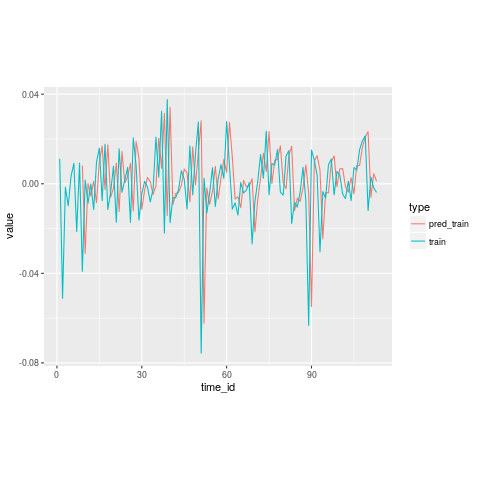

In [13]:
  [rgraph| 
 
   pred_train <- model %>% predict(X_train, batch_size = 1)

   pred_train <- denormalize(pred_train, minval, maxval)
   pred_train_undiff <- pred_train + intl[(lstm_num_timesteps+1):(length(intl)-1)] 
   c(length(intl), length(pred_train))
   df <- data_frame(time_id = 1:113,
                    train = intl,
                    pred_train = c(rep(NA, lstm_num_timesteps+1), pred_train_undiff))       
   df <- df %>% gather(key = 'type', value = 'value', train:pred_train)
   ggplot(df, aes(x = time_id, y = value)) + geom_line(aes(color = type)) + theme(aspect.ratio=0.8)
   |]

Not bad for such a short training time, is it? :-)